<a href="https://colab.research.google.com/github/ninichang/py-and-fs/blob/master/ML_Assignment_4_Gaussian_Processes_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
import scipy.stats as stats

 Write a program in python to implement the full Bayesian inference on Gaussian variables for curve fitting problem. Follow the instructions below: 

### 1. Generate 50 2D-data points using the following function: $y=sin(x^2+1)$

In [41]:
X = np.linspace(0, 1, 10) ; Y = np.sin(X**2+1)
data = np.stack((X, Y), axis=-1) ; print('First 5 rows of generated data:\n', data[0:5])

First 5 rows of generated data:
 [[0.         0.84147098]
 [0.11111111 0.84807709]
 [0.22222222 0.86711592]
 [0.33333333 0.8961922 ]
 [0.44444444 0.93114154]]


###  2. Add Gaussian random noise to the data 

In [42]:
def add_noise(y_curve) :
    mu = 0 ; sigma = 0.05
    noise = np.random.normal(mu, sigma, len(y_curve))
    y_noise = y_curve + noise
    return y_noise

Y_noise = add_noise(Y)

### 3. Show the original curve line and the noisy data. 

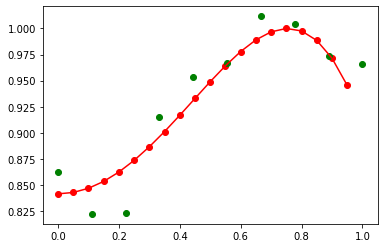

In [43]:
# The red line is the original curve based on the equation. The green dots are the noisy data. 
X_coor = np.arange(0,1,0.05) ; Y_coor = np.sin(X_coor**2+1)
plt.scatter(X_coor, Y_coor, color="red")
plt.plot(X_coor, Y_coor, '-g', label='function', color="red")
plt.scatter(X, Y_noise, color="green");

### 4. Compute the Gaussian process prediction of every input data sequentially, where each input data is taken randomly from the noise data.

In [44]:
def gaussian_basis(xn, mu, sigma):
    return np.exp(-((xn-mu)**2)/(2*sigma ** 2))

def gram_matrix(xn, M, alpha, sigma):
  big_phi = np.ones((len(xn), 1))
  for m_index in range(1, M):
        big_phi = np.c_[big_phi, gaussian_basis(xn, sigma*m_index, sigma)]
  return 1/alpha* np.dot(big_phi, big_phi.T)

def basis_kernel(xi, xj, M, alpha, sigma):
  phi_xi = [] ; phi_xj = []
  for i in range(M):
    phi_xi.append(gaussian_basis(xi, sigma*i, sigma))
    phi_xj.append(gaussian_basis(xj, sigma*i, sigma))
  phi_xi = np.reshape(phi_xi, (M, 1))
  phi_xj = np.reshape(phi_xj, (M, 1))
  return phi_xi, phi_xj

def k_star_func(kernel_func, xn, x_star, M, alpha, sigma):
  k_star = []
  for i in range(len(xn)):
    phi_xi, phi_xj = kernel_func(xn[i], x_star, M, alpha, sigma)
    k_star.append(1/alpha*np.dot(phi_xi.T, phi_xj))
  return np.reshape(k_star, (len(xn), 1))

[ 0.09587359 -0.01257049 -0.01192505  0.07970535  0.11733484  0.13100389
  0.17509848  0.16754273  0.13774834  0.12523912] [-22.31813988   1.27311644   1.27309199   1.27308951   1.27309084
   1.27309084   1.27308951   1.27309199   1.2731155    1.20786271]


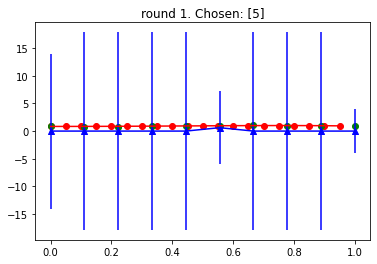

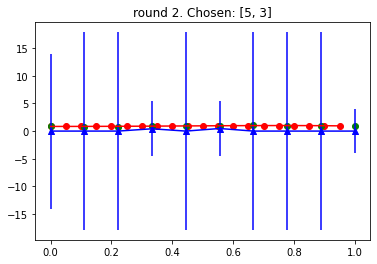

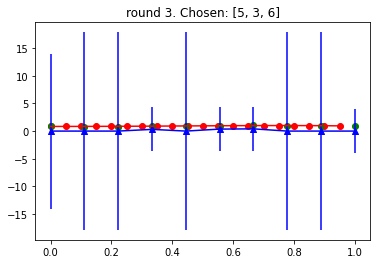

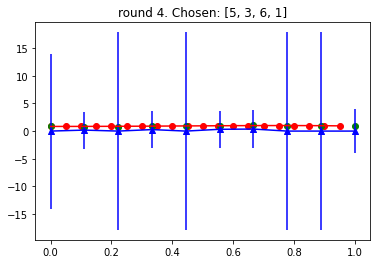

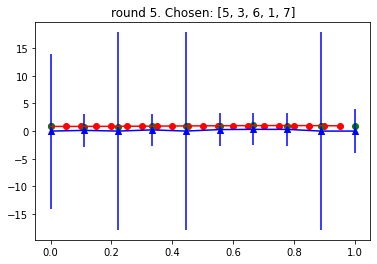

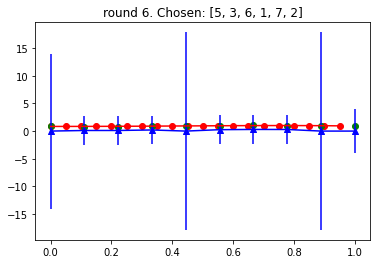

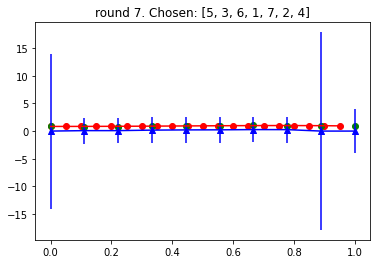

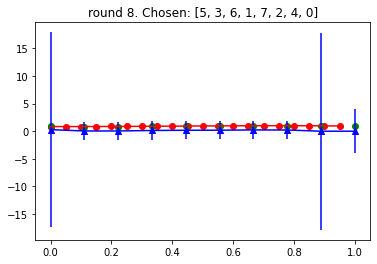

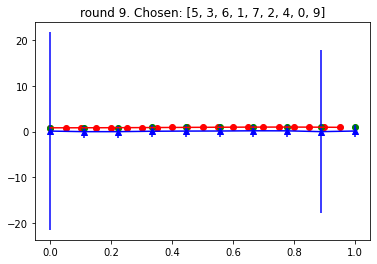

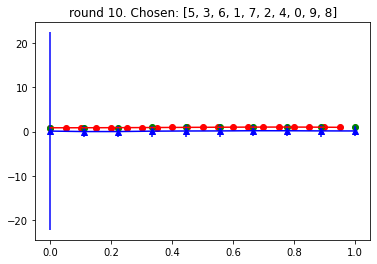

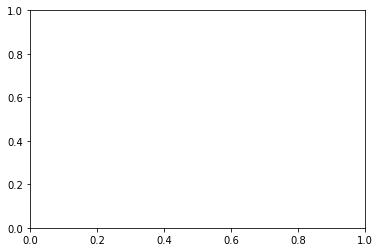

In [75]:
def gaussian_process(xn, tn, M, alpha, beta):
  # ncol = 5 ; nrow = int(50/ncol)
  # fig, axs = plt.subplots(nrow, ncol, figsize=(30, 40))    

  sigma = 1/M
  chosen_x = [] ; chosen_x_index = [] ; xn_copy = xn ; round_index = 1 ;
  
  for round_index in range(1, len(xn)+1):
    
    m_stars = [] ; sigma_stars = []
    x_star = np.random.choice(xn_copy) ; chosen_x.append(x_star)
    chosen_x_index.append(int(np.where(xn == x_star)[0])) ; 
    xn_copy = np.delete(xn_copy, np.where(xn_copy == x_star)) 

    xs = np.reshape(xn[chosen_x_index], (round_index, 1)) 
    ts = np.reshape(tn[chosen_x_index], (round_index, 1))

    plt.scatter(X_coor, Y_coor, color="red") ;  plt.plot(X_coor, Y_coor, '-g', label='function', color="red")
    plt.scatter(X, Y_noise, color="green");

    offset = tn[int(np.where(xn == x_star)[0])]

    for i in range(len(xn)):
      x_star = xn[i]
      k_star = k_star_func(basis_kernel, xs, x_star, M, alpha, sigma)
      cn_inv = np.linalg.inv(1/beta * np.identity(round_index) + gram_matrix(xs, M, alpha, sigma))
      m_star = np.dot(np.dot(k_star.T, cn_inv), ts)
      phi_x_star = basis_kernel(x_star, x_star, M, alpha, sigma)[0]
      c_star = 1/beta + 1/alpha * np.dot(phi_x_star.T, phi_x_star)
      sigma_star = c_star - np.dot(np.dot(k_star.T, cn_inv), k_star)

      m_stars.append(m_star)
      sigma_stars.append(sigma_star)

    plt.errorbar(xn, m_stars, np.squeeze(sigma_stars), color="blue")
    plt.scatter(xn, m_stars, marker='^', color="blue")

    title = 'round ' + str(round_index) + '. Chosen: ' + str(chosen_x_index) ; plt.title(title);
    plt.subplots(1, 1)
  return np.squeeze(m_stars), np.squeeze(sigma_stars)


M = 50 ; alpha = 0.1 ; beta = 6
m_stars, sigma_stars = gaussian_process(X, Y_noise, M, alpha, beta)
print(m_stars , sigma_stars)

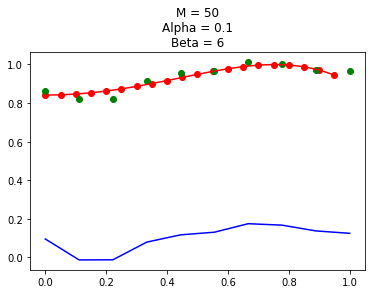

In [76]:
plt.scatter(X_coor, Y_coor, color="red") ;  plt.plot(X_coor, Y_coor, '-g', label='function', color="red")
plt.scatter(X, Y_noise, color="green");
plt.plot(X, m_stars, '-g', label='function', color="blue"); 
title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) ; plt.title(title);
# plt.errorbar(X, m_stars, sigma_stars, color="blue")

### 5.  Use the kernel we discuss in class (textbook's Eq. (6.63), page 307), by setting thetas: (1.0, 4.0, 0.0, 0.0) 

In [ ]:
def new_kernel()



def basis_kernel(xi, xj, M, alpha, sigma):
  phi_xi = [] ; phi_xj = []
  for i in range(M):
    phi_xi.append(gaussian_basis(xi, sigma*i, sigma))
    phi_xj.append(gaussian_basis(xj, sigma*i, sigma))
  phi_xi = np.reshape(phi_xi, (M, 1))
  phi_xj = np.reshape(phi_xj, (M, 1))
  return phi_xi, phi_xj

Estimated w:  [0.66593366 0.16299929 0.02965988 0.28005083]


### 6.  Experiment with your code by changing beta, and explain what beta is for and how it affects the results. 

Part 1.6: Changing alpha


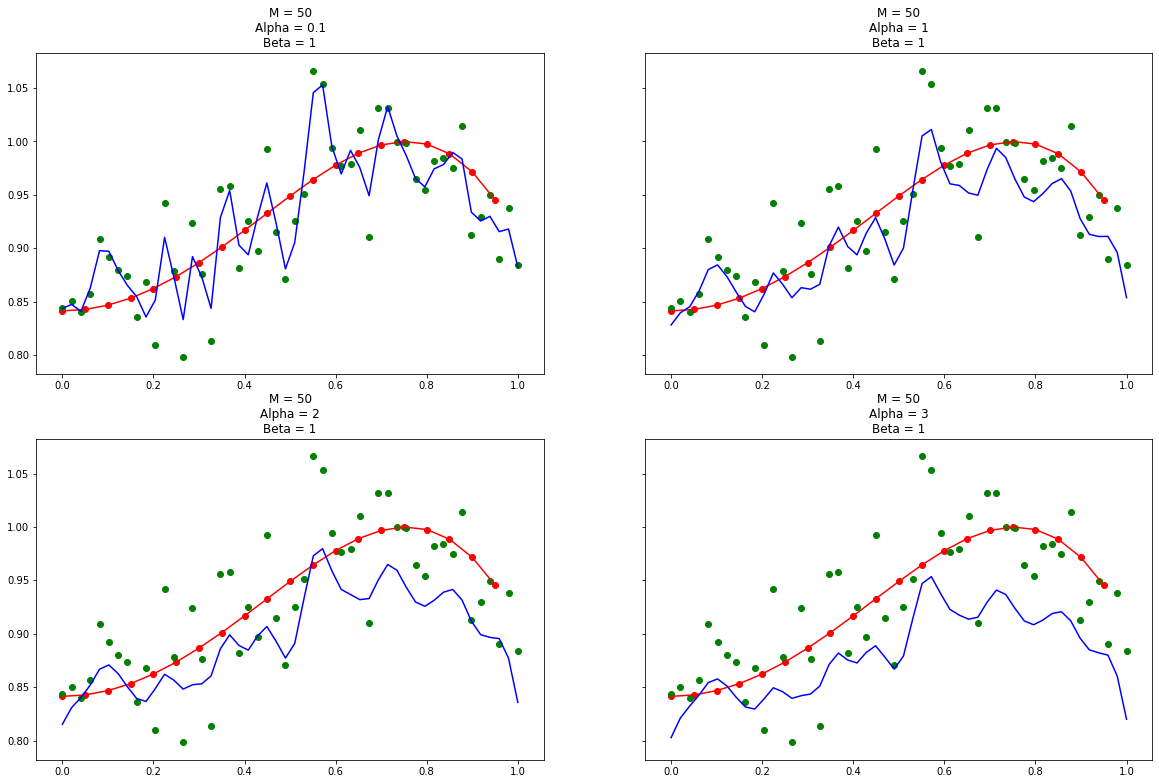

In [ ]:
print('Part 1.6: Changing alpha')

fig, axs = plt.subplots(2, 2, figsize=(20,13), sharey=True)
M = 50 ; alpha = 0.1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[0, 0].scatter(X_coor, Y_coor, color="red")
axs[0, 0].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[0, 0].scatter(X, Y_noise, color="green");
axs[0, 0].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[0, 0].set_title(title);

M = 50 ; alpha = 1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[0, 1].scatter(X_coor, Y_coor, color="red")
axs[0, 1].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[0, 1].scatter(X, Y_noise, color="green");
axs[0, 1].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[0, 1].set_title(title);

M = 50 ; alpha = 2 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[1, 0].scatter(X_coor, Y_coor, color="red")
axs[1, 0].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[1, 0].scatter(X, Y_noise, color="green");
axs[1, 0].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[1, 0].set_title(title);


M = 50 ; alpha = 3 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[1, 1].scatter(X_coor, Y_coor, color="red")
axs[1, 1].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[1, 1].scatter(X, Y_noise, color="green");
axs[1, 1].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[1, 1].set_title(title);


From the results of changing alpha and beta above, we see that increasing alpha reduces overfitting.

### 7.  Show your best prediction results for all 50 data one by one: 

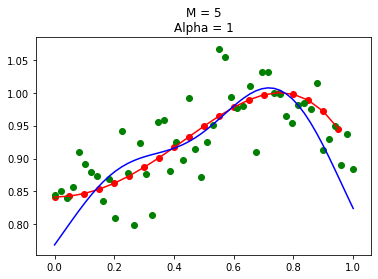

In [ ]:
M = 5 ; alpha = 1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)

plt.scatter(X_coor, Y_coor, color="red") ; plt.plot(X_coor, Y_coor, '-g', label='function', color="red")
plt.scatter(X, Y_noise, color="green"); plt.plot(X, predicted_y, '-g', label='function', color="blue");

title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha)
plt.title(title);

### 8.  Change the kernel's parameters, thetas: (1.0, 64.0, 10.0, 5.0), and show the results. 

Part 1.8: Changing M


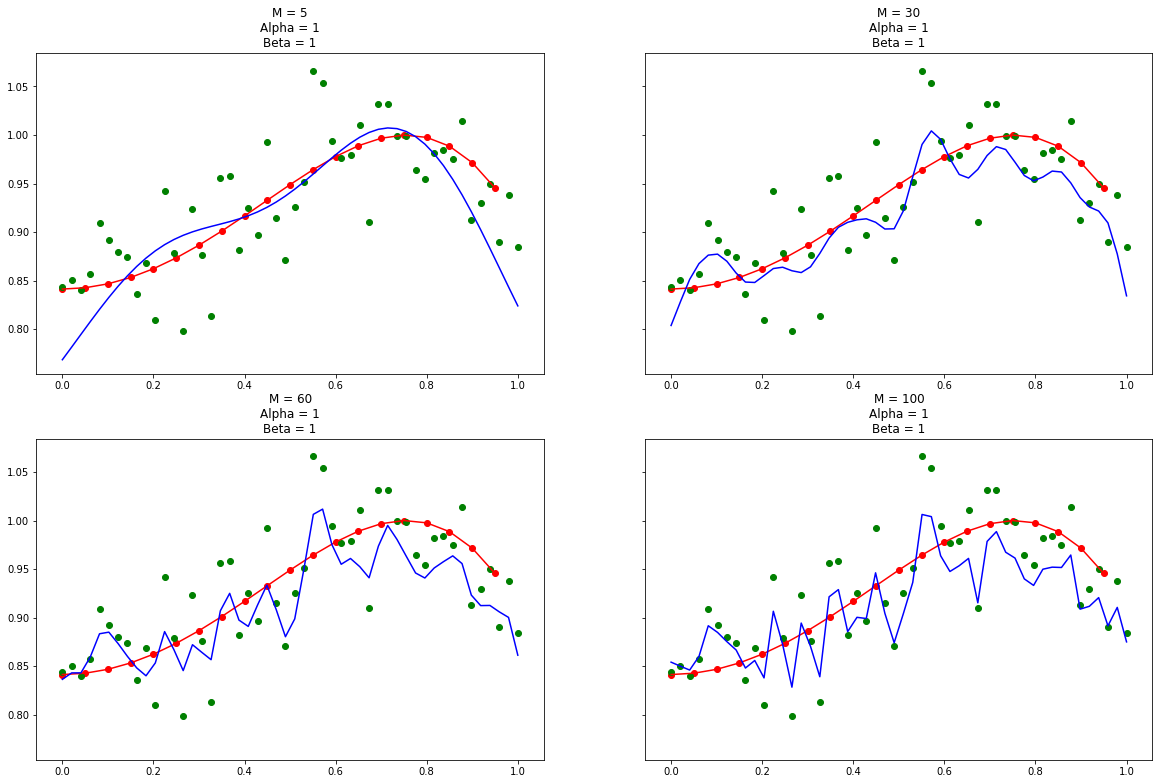

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,13), sharey=True)
print('Part 1.8: Changing M')

M = 5 ; alpha = 1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[0, 0].scatter(X_coor, Y_coor, color="red")
axs[0, 0].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[0, 0].scatter(X, Y_noise, color="green");
axs[0, 0].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[0, 0].set_title(title);

M = 30 ; alpha = 1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[0, 1].scatter(X_coor, Y_coor, color="red")
axs[0, 1].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[0, 1].scatter(X, Y_noise, color="green");
axs[0, 1].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[0, 1].set_title(title);

M = 60 ; alpha = 1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[1, 0].scatter(X_coor, Y_coor, color="red")
axs[1, 0].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[1, 0].scatter(X, Y_noise, color="green");
axs[1, 0].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[1, 0].set_title(title);


M = 100 ; alpha = 1 ; beta = 1

w, predicted_y = full_bayesian(Y_noise, X, M, alpha, beta)
axs[1, 1].scatter(X_coor, Y_coor, color="red")
axs[1, 1].plot(X_coor, Y_coor, '-g', label='function', color="red")
axs[1, 1].scatter(X, Y_noise, color="green");
axs[1, 1].plot(X, predicted_y, '-g', label='function', color="blue"); title = 'M = '+ str(M) + '\nAlpha = '+ str(alpha) + '\nBeta = '+ str(beta) 
axs[1, 1].set_title(title);


Larger M gives more overfitting as the curve gets increasingly similar to the exact distribution of the data points. The uncertainty of prediction increases as M increases 

### 9.  Explain what the effects of changing to this kernel on the prediction. 

### 10.  Change the kernel's parameters, thetas: (1.0, 0.25, 0.0, 0.0), and show the results. 

In [ ]:
X = np.linspace(0, 1, 50) ; Y = np.sin(X**2+1)
data = np.stack((X, Y), axis=-1) ; print('First 5 rows of generated data:\n', data[0:5])

First 5 rows of generated data:
 [[0.         0.84147098]
 [0.02040816 0.84169594]
 [0.04081633 0.84236995]
 [0.06122449 0.84349036]
 [0.08163265 0.84505279]]


###  11.  Explain what the effects of changing to this kernel on the prediction. 